In [1]:
import numpy as np
from PIL import Image
import cv2
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True' #ошибка ОС на локальной машине
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
import pickle
from tqdm import tqdm, tqdm_notebook
from pathlib import Path, WindowsPath
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
import random
#зануляем рандом каждый раз
def zero_random():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

zero_random()

In [3]:
torch.cuda.is_available()

True

In [4]:
CUDA_LAUNCH_BLOCKING=1. #ошибка ОС на локальной машине

In [5]:
DATA_MODES = ['train', 'val', 'test', 'augment']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class RusDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки/список PIL картинок из памяти
        if type(files[0]) == WindowsPath:
            self.files = sorted(files)
        else:
            self.files = files
        # режим работы
        self.mode = mode
        
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            #сохраняем label_encoder для последующей правильной расшифровки
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode in ['train', 'val']:
            transform = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(mode=None),    
                
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           transforms.Grayscale(),
                                           ])
        elif self.mode == 'augment':
            transform = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(mode=None),    
                transforms.RandomPerspective(distortion_scale=0.3, fill = 255,p=0.5),
                transforms.RandomRotation((-40,40), resample=False,  expand=False, fill = 255,center=None),
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ])                
        else:
            transform = transforms.Compose([
                
                transforms.ToTensor(),
                transforms.RandomInvert(p=1),
                transforms.CenterCrop(400), #добавляем белую рамку, лучше распознаются буквы, не примыкающие к краю изображения
                transforms.RandomInvert(p=1),
                transforms.Resize((224, 224)),
                
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.Grayscale(),
            ])
        if type(self.files[index]) == WindowsPath: #различная подача результатов обработки фото и тренировочного датасета
            x = self.load_sample(self.files[index])
        else:
            x = self.files[index]
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
#Imshow для тензоров
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#тренировочный датасет
TRAIN_DIR = Path('dataset/test')

In [9]:
#устранени е дисбаланса классов
#находим максимальное число файлов
mx = 0
dir_count = {}
for folder in os.listdir(TRAIN_DIR):
    files = os.listdir(path=str(TRAIN_DIR)+'\\'+folder)
    dir_count[folder] = len(files)
    if len(files) > mx:
        mx = len(files)

In [10]:
# для каждой папки загружаем фото и применяем трансформации для увеличения выборки
for folder in os.listdir(TRAIN_DIR):
    AUG_DIR = Path('dataset\\test\\'+folder)
    aug_files = sorted(list(AUG_DIR.rglob('*.jpeg')))
    aug_dataset = RusDataset(aug_files, mode='augment')
    for i in range(1200-dir_count[folder]):#добавляем столько файлов, сколько осталось до максимального числа
        random_characters = int(np.random.uniform(0,dir_count[folder]))
        im_val, label = aug_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    aug_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        mean = np.array([0.485, 0.456, 0.406])#нормализация тензора
        std = np.array([0.229, 0.224, 0.225])
        name = Path('dataset\\test\\'+folder+'\\'+os.listdir(AUG_DIR)[0][:1] + str(i) +os.listdir(AUG_DIR)[0][1:])
        plt.imsave(name, (std * im_val.data.cpu().permute(1, 2, 0).numpy()+mean).clip(0, 1))
    print(folder) 

C:\Users\Katerina\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1230: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
C:\Users\Katerina\anaconda3\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.lin

Ё
А


KeyboardInterrupt: 

In [10]:
#разделение на тренировочную и валидационную выборку
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.4, \
                                          stratify=train_val_labels)
val_dataset = RusDataset(val_files, mode='val')

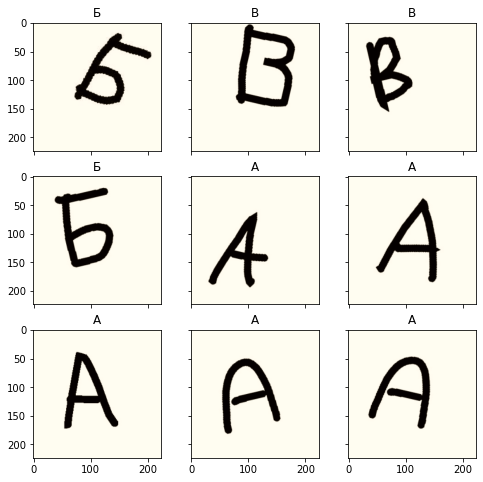

In [11]:
#проверка правильности отображения
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [12]:
# Строим сеть, 5 слоёв
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2),
            
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
#Эпоха обучения
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
#Валидация эпохи
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
#тренировка
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10.0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), amsgrad=True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
                # сохраняем лучшую модель
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(simple_cnn.state_dict(), "best_model.pth")
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [107]:
#ВНИМАНИЕ!
#тренировка. Сохраняем accuracy и lost для оценки наличия или отсутствия переобучения
valacc = []
valoss = []
zero_random()
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
if val_dataset is None:
    val_dataset = RusDataset(val_files, mode='val')
train_dataset = RusDataset(train_files, mode='train')
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=50)
loss, acc, val_loss, val_acc = zip(*history)
valacc.append(val_acc[-1].item())
valoss.append(val_loss[0])

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]C:\Users\Katerina\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 0.9783891242574462


epoch:  10%|███████▌                                                                   | 1/10 [04:37<41:37, 277.54s/it]


Epoch 001 train_loss: 0.9784     val_loss 0.5078 train_acc 0.7230 val_acc 0.8499
loss 0.3430746317878742


epoch:  20%|███████████████                                                            | 2/10 [07:46<30:02, 225.31s/it]


Epoch 002 train_loss: 0.3431     val_loss 0.3125 train_acc 0.8944 val_acc 0.9119
loss 0.15676501639857998


epoch:  30%|██████████████████████▌                                                    | 3/10 [10:55<24:21, 208.85s/it]


Epoch 003 train_loss: 0.1568     val_loss 0.2731 train_acc 0.9506 val_acc 0.9240
loss 0.0944116885807351


epoch:  40%|██████████████████████████████                                             | 4/10 [14:06<20:11, 201.97s/it]


Epoch 004 train_loss: 0.0944     val_loss 0.2313 train_acc 0.9696 val_acc 0.9369
loss 0.08195005409191801


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [17:15<16:25, 197.08s/it]


Epoch 005 train_loss: 0.0820     val_loss 0.2608 train_acc 0.9732 val_acc 0.9308
loss 0.04198041775373402


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [20:25<12:58, 194.57s/it]


Epoch 006 train_loss: 0.0420     val_loss 0.2412 train_acc 0.9866 val_acc 0.9437
loss 0.02983465894461615


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [23:37<09:41, 193.71s/it]


Epoch 007 train_loss: 0.0298     val_loss 0.2229 train_acc 0.9902 val_acc 0.9499
loss 0.020428048604858137


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [26:49<06:26, 193.16s/it]


Epoch 008 train_loss: 0.0204     val_loss 0.2154 train_acc 0.9935 val_acc 0.9508
loss 0.008973846713187067


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [30:00<03:12, 192.56s/it]


Epoch 009 train_loss: 0.0090     val_loss 0.2367 train_acc 0.9970 val_acc 0.9538
loss 0.012978207345893967


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [33:12<00:00, 199.26s/it]


Epoch 010 train_loss: 0.0130     val_loss 0.2620 train_acc 0.9960 val_acc 0.9460


In [17]:
#Открываем картинку для предсказания
image_file = "IMG.JPG"
img = cv2.imread(image_file)
"""if max(img.shape) > 1024: #масштабирование до размеров, помещающихся в экран на данном проекте.
    scale_in = 1024/max(img.shape)
    img = cv2.resize(img, (int(img.shape[1] * scale_in), int(img.shape[0] * scale_in)), interpolation = cv2.INTER_AREA)"""
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#порог отсечения фоновых пикселей. thresh - монохромное чёрно-белое изображение
ret, thresh = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY)
n1n = 10
img_erode = cv2.erode(thresh, np.ones((n1n, n1n), np.uint8), iterations=1) #размытие для сглаживания контуров
# находим контуры
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

output = thresh.copy()
letters = []
dataset_create = []
for idx, contour in enumerate(contours): #ищем по контурам буквы
    (x, y, w, h) = cv2.boundingRect(contour)
    if hierarchy[0][idx][3] == 0:
        cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
        letter_crop = thresh[y:y + h, x:x + w]
            # приводим картинки с буквами к форме квадрата
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            # подгоняем сверху и снизу
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = letter_crop
        elif w < h:
            # подгоняемм слева и справа
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = letter_crop
        else:
            letter_square = letter_crop
        # изменяем размер к размеру изображений модели и поворачиваем на 90 градусов
        out_size = 224
        letter_square = np.rot90(letter_square, 1 )
        letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
        
#делаем контуры букв толще и более целыми        
for elem in letters:
    elem = elem[-1]
    ret, thresh = cv2.threshold(elem, 0, 255, cv2.THRESH_BINARY)
    n1n = 20
    elem_erode = cv2.erode(thresh, np.ones((n1n, n1n), np.uint8), iterations=1) #размытие для сглаживания контуров
    contours, hierarchy = cv2.findContours(elem_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    output = elem.copy()

    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
    dataset_create.insert(0, Image.fromarray(cv2.merge((elem_erode, elem_erode, elem_erode))))

cv2.waitKey(0)

-1

In [18]:
#Тестовый датасет
test_files = dataset_create#sorted(list(TEST_DIR.rglob('*.jpeg')))
test_dataset = RusDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=7)

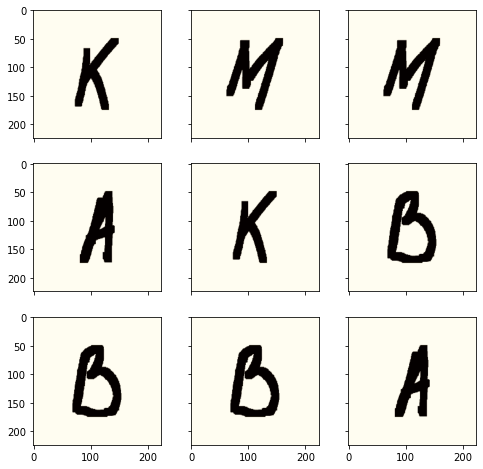

In [19]:
#проверка правильности отображения
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5))
    im_test = test_dataset[random_characters]
    imshow(im_test.data.cpu(), \
          plt_ax=fig_x)

In [20]:
#если запускаем без обучения
zero_random()
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
#загрузка лучшей модели
simple_cnn.load_state_dict(torch.load('best_model095.pth')) #имя лучшей модели. 
#Если обучение было проведено не полностью, то best_model095.pth, иначе best_model.pth

<All keys matched successfully>

In [21]:
#делаем предсказания, 
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
probs = predict(simple_cnn, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

C:\Users\Katerina\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
#сохраняем в текстовый файл
with open("output.txt",'w') as out_txt:
    for elem in preds:
        out_txt.write(elem)
        out_txt.write(' ')

In [22]:
#прочитаем и здесь
for elem in preds:
    print(elem, end = ' ')

А В Г К М Н Е 